In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import os
import numpy as np
import math
import matplotlib


In [2]:
def dataframe_of_f1scores(excel_path:str, sheet_name:str, filetype:list, range_ids, patient_ids=False):
    """
    The function takes in an excel file and creates a list of paths to the wanted file(s) (filetype).
    The wanted files are then converted to dataframes, and a singel dataframe containing all the
    'f1_scores' in the wanted files is returned.
    
    
    excel_path: path to excel file containing the paths to folders with experiment results
    sheet_name: name of the excel sheet you want to create a dataframe of
    filetype: filename of the file you want to collect from the result folder
    
    Returns a dataframe with all of f1_scores for the filetype for a given dataset.
    """
    dataframe = pd.read_excel(excel_path, sheet_name=sheet_name) #Create dataframe of excel sheet
    paths = list(dataframe['Result path']) #Get a list of folderpaths were the results are saved
    learning_rates = list(dataframe['Learning rate'])
    loss_functions = list(dataframe['Loss function'])
    IDs = list(dataframe['Experiment ID'])
    file_paths_352 = [] #List of paths for images with dimension 352x352
    file_paths_256 = [] #List of paths for images with dimension 256x256
    df = pd.DataFrame()

    for file in filetype:
        
        for i in range_ids:
            
            if (dataframe['Dataset'][0] == 'Oxytarget'): #If the dataset is Oxytarget then all the images have the same dimensions.
                paths[i] = paths[i] + '/' + file #List of paths for the patient.csv files
                if os.path.isfile(paths[i]): #Check if the file path exists
                    if df.empty: #Check if the dataframe is empty
                        df = pd.read_csv(paths[i]) #Add result to dataframe
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True) #Rename column
                        #df = df.rename(columns={'f1_score': IDs[i]})
                    else:
                        #If the dataframe is not empty, add columns with the score from the other results
                        df_temp = pd.read_csv(paths[i])
                        df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                        df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[i])+ '+' +loss_functions[i]}, inplace=True)
                        #df = df.rename(columns={'f1_score': IDs[i]})
                
                    
            
            else: #For other datasets the images are of two different dimensions
                if file.endswith('352.csv'):
                    file_paths_352.append(str(paths[i]) + '/' + file)
                else:
                    file_paths_256.append(str(paths[i]) + '/' + file)
                
    if not dataframe['Dataset'][0] == 'Oxytarget':
        for i in range(len(file_paths_352)):
            if os.path.isfile(file_paths_352[i]) and os.path.isfile(file_paths_256[i]):

                if df.empty: #Check if the dataframe is empty
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df = df_352.append(df_256, ignore_index=True)
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                
                else:
                    #If the dataframe is not empty, add columns with the score from the other results
                    df_352 = pd.read_csv(file_paths_352[i])
                    df_256 = pd.read_csv(file_paths_256[i])
                    df_temp = df_352.append(df_256, ignore_index=True)
                    df = df.join(df_temp.set_index('patient_ids'), on='patient_ids')
                    df.rename(columns={'f1_score':'{:.0e}'.format(learning_rates[range_ids[i]])+ '+' +loss_functions[range_ids[i]]}, inplace=True) #Rename column
                    #df = df.rename(columns={'f1_score': IDs[i]})
                    
    if not patient_ids:
        df = df.drop(['patient_ids'], axis=1)
    
    return df

In [3]:
def swap_columns(df, c1, c2):
    """
    The function swaps the position of two columns (c1 and c2) in a dataframe (df).
    Returns new dataframe with swapped columns.
    """
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df = df.rename(columns={c1:c2, c2:c1})
    return df

In [70]:
def boxplot(dataframe, order, fontsize, labelsize, save=False):
    """
    The function creates boxplots based on learning rates and loss functions
    """
    fig = plt.figure()
    g = sns.FacetGrid(dataframe, col='Learning rate', row='Loss function', margin_titles=True)
    g.map(sns.violinplot,'Data', 'value', order=order, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')


        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', 'DSC')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    g.set(ylim=(-0.35,1.1))
    #g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig('hyperparameters_violinplot.pdf')
    
    

## Boxplots tuning hyperparameters (learning rate and loss function)

In [71]:
def main():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    ids_Oxy = [5,6,7,8,9,10]
    ids_LARC = [5,6,7,8,9,10]
    ids_Comb = [0,1,2,3,4,5]
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC',['patient_352.csv','patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb) 
    
    
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    #Column-names to be swapped
    col_names = list(Oxy.columns)
    
    for key in dictionary:               
        #Swapping order of columns
        dictionary[key] = swap_columns(dictionary[key], col_names[1], col_names[0])
        dictionary[key] = swap_columns(dictionary[key], col_names[4], col_names[3])
        
        #Re-organize the dataframe
        dictionary[key]['Data'] = key
    
    #Create one dataframe with all the datasets
    df = pd.concat([dictionary['OxyTarget'], dictionary['LARC-RRP'], dictionary['Combined']])
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    df[['Learning rate','Loss function']] = df.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
    
    #Plot as boxplots
    order = ['OxyTarget','LARC-RRP','Combined']
    boxplot(df, order, 12, 12, save=False)
    

<Figure size 432x288 with 0 Axes>

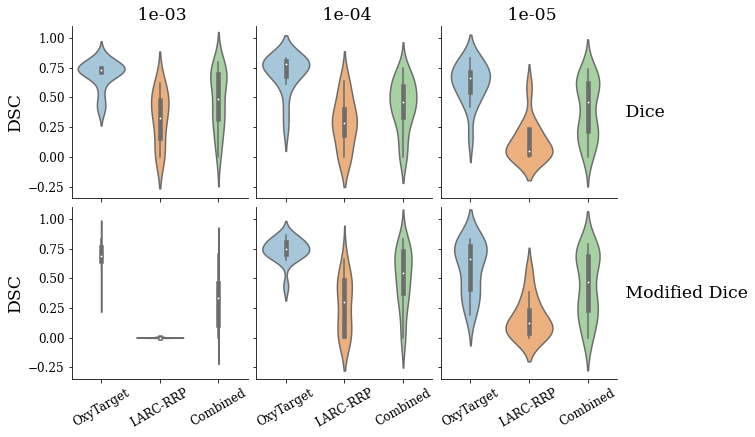

In [72]:
main()

## Scatter plots

In [319]:
def scatterplot(dataframe, x_value, y_value, hue=None, save=False):
    fig = plt.figure(figsize=(11,8))
    sns.scatterplot(data=dataframe, x=x_value, y=y_value, hue=hue, palette='deep')
    plt.ylabel('DSC')
    plt.xlabel('Patient IDs')
    plt.title('Dataset: Combined, Learning rate: 0.00001')
    plt.ylim(-0.05,1.05)
    plt.show()
    
    if save:
        fig.savefig('scatter_Combined_ID_6.pdf')

<ipython-input-322-35e250425d50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Combined['Dimension'][26:] = 256
/Users/ingvild/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


    patient_ids    1e-04+dice    1e-03+dice    1e-05+dice  \
0           8.0  3.742796e-01  4.586493e-01  3.168455e-01   
1          10.0  3.824719e-01  3.162307e-01  4.575202e-01   
2          33.0  1.482200e-01  1.273156e-01  7.769662e-02   
3          48.0  3.509996e-01  4.041166e-01  4.164535e-01   
4          54.0  4.541155e-01  4.588831e-01  3.141851e-01   
5          64.0  1.849959e-01  3.257951e-01  7.187295e-02   
6          73.0  3.571896e-01  4.558449e-01  1.755793e-01   
7          80.0  6.356998e-01  6.698123e-01  5.278915e-01   
8          90.0  3.550093e-01  4.452312e-01  2.035720e-01   
9          91.0  7.182102e-14  6.426570e-14  6.940974e-14   
10       1115.0  6.850677e-01  7.025625e-01  7.101163e-01   
11       1121.0  7.360561e-01  6.678380e-01  6.321875e-01   
12       1122.0  5.763660e-01  4.380303e-01  4.175091e-01   
13       1124.0  6.723814e-02  1.161710e-01  1.917404e-01   
14       1133.0  6.986026e-01  6.368142e-01  6.447318e-01   
15       1138.0  6.00843

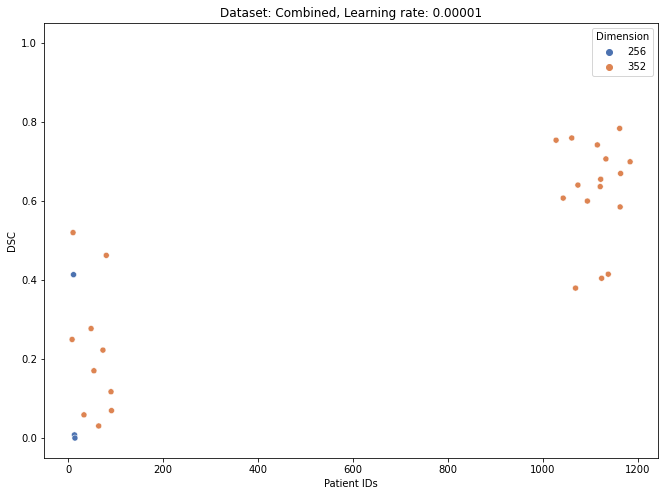

In [322]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
Combined = dataframe_of_f1scores(excel_path, 'Combined',['patient_352.csv','patient_256.csv'], [0,1,2,3,4,5], patient_ids=True)
Combined['Dimension'] = 352
Combined['Dimension'][26:] = 256
print(Combined)
scatterplot(Combined, 'patient_ids', '1e-05+modified dice', hue='Dimension',save=True)

## Boxplot augmentation

In [458]:
def boxplot_aug(dataframe, fontsize, labelsize, title, colors, save=False):
    
    fig = plt.figure(figsize=(11,8))
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
    sns.violinplot(x=dataframe['Parameters'], y=dataframe['value'], palette=colors)
    plt.xlabel(None)
    plt.ylabel('DSC')
    plt.title(title)
    plt.xticks(rotation=30)
    #plt.ylim(-0.05,1.05)
    plt.ylim(-0.35,1.15)
    plt.show()
    
    if save:
        fig.savefig('Oxy_norm_violin.pdf')
    

In [459]:
def catplot_aug(dataframe, fontsize, labelsize, title, order, colors, save=False):
    
    fig = plt.figure()
    sns.set_palette(sns.color_palette(colors))
    p = {'No': sns.color_palette(colors, 1), 'Default': sns.color_palette(colors, 1), 'Best Combination': sns.color_palette(colors, 1)}
    g = sns.catplot(x='Data', y='value', col='Parameters', hue='Parameters', data=dataframe, kind='violin', palette=p, margin_titles=True)
    #g.map(sns.violinplot,'Data', 'value', order=order, palette=['#9ecae1','#fdae6b','#a1d99b']) #['#3182bd','#e6550d','#31a354']) ['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    matplotlib.rcParams['font.family'] = "serif"
    matplotlib.rcParams.update({'xtick.labelsize': labelsize})
   
    
    #ylabels = ['DSC', 'Modified DSC']
    row = 0
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')
        
        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    #'',
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
        row += 1
    
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', 'DSC')
    #g.axes.flat[3].set_ylabel('Modified DSC', fontsize='x-large')
    #g.axes.flat[3].set_text('', fontsize='x-large')
    g.set(ylim=(-0.35,1.1))
    #g.set(ylim=(-0.05,1.05))
    plt.show()
    
    if save:
        g.savefig('Comb_normalization_violinplot.pdf')
    
    

In [460]:
def main_aug():
    
    excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
    
    #Define correct experiments (IDs)
    ids_LARC = [5,21,22,24]
    ids_Oxy = [5,14,15,16]
    ids_Comb = [0,14,13,15]
    
    #Creating dataframes of det f1 scores of the validation patients
    Oxy = dataframe_of_f1scores(excel_path, 'Oxy_new', ['patient.csv'], ids_Oxy)
    LARC = dataframe_of_f1scores(excel_path, 'LARC', ['patient_352.csv', 'patient_256.csv'], ids_LARC)
    Combined = dataframe_of_f1scores(excel_path, 'Combined_new',['patient_352.csv','patient_256.csv'], ids_Comb)
    print(Combined)
    #Creating dictionary of dataframes
    dictionary = {'OxyTarget': Oxy, 'LARC-RRP': LARC, 'Combined': Combined}
    
    col_names_aug = ['No', 'Default', 'Best Combination']
    col_names_norm = ['No', 'Z-Score', 'Matched Hist', 'Matched Hist + Z-Score']

    for key in dictionary:
        print(key)
        for i in range(len(dictionary[key].columns)):
            dictionary[key].columns.values[i] = col_names_norm[i]
            print(dictionary[key].median())
        dictionary[key]['Data'] = key
        dictionary[key] = pd.melt(dictionary[key], id_vars=['Data'], var_name=['Parameters'])
        
        
    colors_Oxy = ['#9ecae1']#['#deebf7','#9ecae1','#3182bd']
    colors_LARC = ['#fdae6b'] #['#fee6ce','#fdae6b','#e6550d']
    colors_Comb = ['#a1d99b']#['#e5f5e0','#a1d99b','#31a354']
    
    boxplot_aug(dictionary['OxyTarget'], 20, 20, '', colors_Oxy, save=True)
    #catplot_aug(dictionary['LARC-RRP'], 20, 20, '', col_names, colors_LARC, save=False)

      1e-04+Dice  1e-04+Modified Dice  1e-04+Modified Dice  \
0   3.671686e-01             0.507238         5.079182e-01   
1   4.616767e-01             0.430496         1.170470e-01   
2   1.861577e-01             0.297437         3.701917e-01   
3   3.914741e-01             0.526312         3.961836e-01   
4   4.935207e-01             0.513766         5.216742e-01   
5   2.062322e-01             0.126080         2.026820e-01   
6   4.691816e-01             0.460785         3.354944e-01   
7   6.970897e-01             0.638360         5.228338e-01   
8   4.477368e-01             0.511292         3.708478e-01   
9   7.061698e-14             0.507499         6.550010e-01   
10  6.226847e-01             0.800600         7.650797e-01   
11  6.133394e-01             0.682754         7.133229e-01   
12  3.906581e-01             0.430426         5.761804e-01   
13  1.369210e-01             0.012487         2.666029e-01   
14  6.780299e-01             0.413367         6.809292e-01   
15  3.07

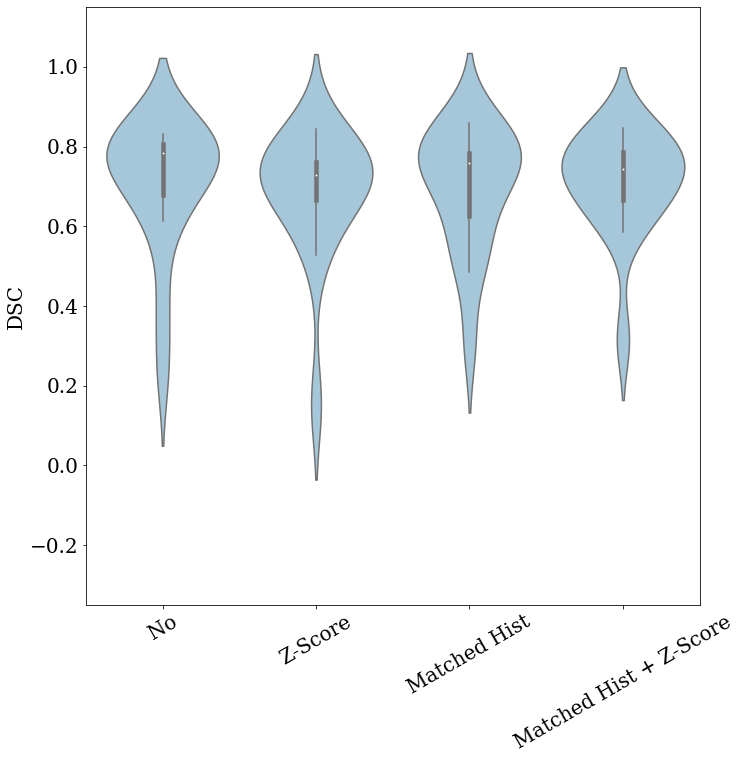

In [461]:
main_aug()

In [369]:
def main_dimensions(dataframe, id1, id2):
    
    path_1_dim = list(dataframe['Result path'])[id1] + '/patient.csv'
    path_2_dim_352 = list(dataframe['Result path'])[id2] + '/patient_352.csv'
    path_2_dim_256 = list(dataframe['Result path'])[id2] + '/patient_256.csv' #Get a list of folderpaths were the results are saved
    
    df1 = pd.read_csv(path_1_dim)
    df1 = df1.rename(columns={'f1_score':'One dimension \n (352x352)'})
    
    df2_352 = pd.read_csv(path_2_dim_352)
    df2_256 = pd.read_csv(path_2_dim_256)
    df = df2_352.append(df2_256, ignore_index=True)
    df2 = df.rename(columns={'f1_score':'Two dimensions \n (352x352),(256x256)'})
    
    df = df2.join(df1.set_index('patient_ids'), on='patient_ids') 
    df = df.drop(['patient_ids'], axis=1)
    
    df['Data'] = 'LARC-RRP'
    df = pd.melt(df, id_vars=['Data'], var_name=['Parameters'])
    colors_LARC = ['#fee6ce','#fdae6b']

    boxplot_aug(df, 20, 20, '', colors_LARC, save=True)

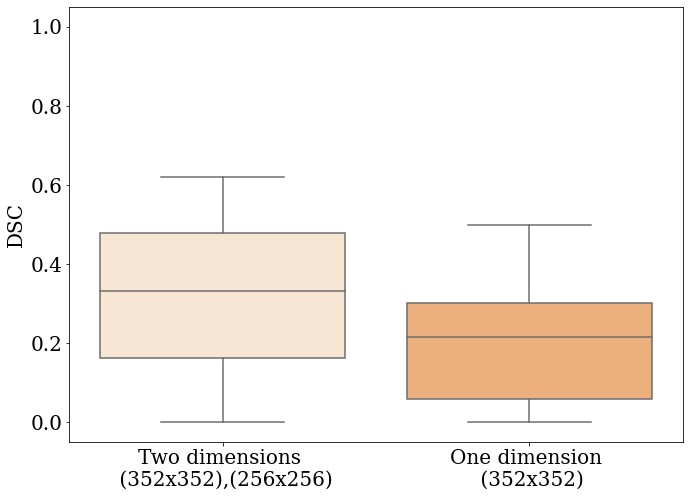

In [213]:
excel_path = '/Volumes/LaCie/MasterThesis_Ingvild/Excel_data/Experiment_plan.xlsx'
LARC_dim = pd.read_excel(excel_path, sheet_name='LARC') #Create dataframe of excel sheet

main_dimensions(LARC_dim, 19,6)